<a href="https://colab.research.google.com/github/cxbxmxcx/Evolutionary-Deep-Learning/blob/main/EDL_2_Discontinuties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
#@title Install Dependencies
!pip install livelossplot --quiet

In [ ]:
#@title Defining Imports
#numpy
import numpy as np
#PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
#statistics
from statistics import mean 
#liveloss plot
from livelossplot import PlotLosses
#plotting
from matplotlib import pyplot as plt

In [ ]:
#@title Setting up GPU -- Runtime -> Change runtime type
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
#@title Setting Hyperparameters
learning_rate = 3.5e-03
epochs = 500
middle_layer = 5
batch_size = 16

# Creating Data

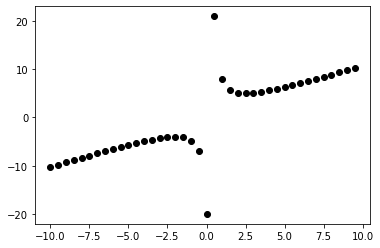

In [ ]:
#@title Creating data from function and reshaping
def function(X):
  return (X * X + 5.) / ( X - .25)

data_step = .5
X = np.reshape(np.arange(-10,10, data_step), (-1, 1))
y = function(X)
inputs = X.shape[1]
plt.plot(X, y, 'o', color='black')

In [ ]:
tensor_x = torch.Tensor(X) # transform to torch tensor
tensor_y = torch.Tensor(y)

dataset = TensorDataset(tensor_x,tensor_y) # create your datset
dataloader = DataLoader(dataset, batch_size= batch_size, shuffle=True) # create your dataloader

# Building the Model

In [ ]:
#@title Define the Model
class Net(nn.Module):
  def __init__(self, inputs, middle):
    super().__init__()
    self.fc1 = nn.Linear(inputs,middle)
    self.bn1 = nn.BatchNorm1d(middle)
    self.fc2 = nn.Linear(middle,middle)
    self.bn2 = nn.BatchNorm1d(middle)
    self.out = nn.Linear(middle,1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.bn1(x)  
    x = F.relu(self.fc2(x))
    x = self.bn2(x)
    x = self.out(x)
    return x

In [ ]:
#@title Create the model
model = Net(X.shape[1], middle_layer)
print(model)

Net(
  (fc1): Linear(in_features=1, out_features=5, bias=True)
  (bn1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=5, out_features=1, bias=True)
)


In [ ]:
#@title Define loss function (criterion) and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

if cuda:
  loss_fn.cuda()
  model.cuda()

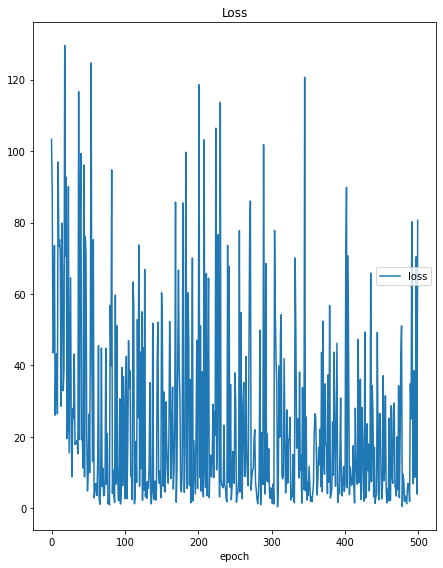

Loss
	loss             	 (min:    0.450, max:  129.572, cur:   80.647)


In [ ]:
#@title Training the Model
liveloss = PlotLosses()
history={}
for i in range(epochs):        
  for X, y in iter(dataloader):
    # wrap the data in variables
    x_batch = Variable(X.type(Tensor))
    y_batch = Variable(y.type(Tensor))                   
    # forward pass
    y_pred = model(x_batch)        
    # compute and print loss
    loss = loss_fn(y_pred, y_batch)  
    history['loss'] = loss.data     
    # reset gradients
    optimizer.zero_grad()        
    # backwards pass
    loss.backward()        
    # step the optimizer - update the weights
    optimizer.step()

  liveloss.update(history)
  liveloss.send() 

In [ ]:
X_a = torch.rand(100,1).clone() * 40 - 20
y_a = model(X_a)
y_a = y_a.detach().numpy()
plt.plot(X_a, y_a, 'o', color='black')

RuntimeError: ignored